# ADMM-T

## Introduction: ADMM, ADMM-GS, ADMM-T

The ADMM-T technique is a variant of ADMM proposed by Mitsuharu Takeori and patented by IBM.

ADMM is a *splitting technique*, namely an algorithm that splits an optimization problem into many subproblems, and coordinates/combines their respective solutions to provide a solution of the original problem.

Specifically, in the context of quantum computing, a first variant of ADMM, here called ADMM-GS, was proposed by [Gambella and Simonetto](https://arxiv.org/abs/2001.02069). ADMM-GS is implemented as a part of Qiskit (tutorial [here](https://qiskit-community.github.io/qiskit-optimization/tutorials/05_admm_optimizer.html)).

ADMM-GS and ADMM-T share the following idea: a problem with binary and continuous variables is split into a binary-only problem, and a continuous-only problem. The former (which is typically hard classically as it is combinatorial) is solved by a quantum algorithm such as QAOA, VQE, etc., while the latter is solved efficiently with a classical solver.

ADMM-T, therefore, coordinates two subsolver:
- A (quantum) solver for binary problems. Typical examples are QAOA, VQE, [GNQA](https://arxiv.org/pdf/2203.13939.pdf), which are all suited for HUBOs or at least QUBOs.
- A (classical) solver for continuous problems. Here we use CPLEX.

ADMM-GS has a more intricate structure than ADMM-T, what makes ADMM-T easier to apply (less hyperparameters, less tuning, smaller problems), and usually faster. The higher complexity of ADMM-GS was designed to provide better convergence, even if that's not always the case (see also discussion below on theoretical convergence).

In order for the problem to allow splitting the discrete part from the continuous part, though, more structure is required, as we discuss below. Let us start saying that ADMM-based approaches typically handle *separable objective functions* (namely, the objective is the sum of one term in the continuous variables and a distinct term in the discrete variables) while allowing for *cross constraints*.


## When it makes sense to apply ADMM-T
The use cases for ADMM-T are:
- When the problem natively contains discrete and continuous variables. Indeed, quantum HUBO solvers are not able to deal with continuous variables, while ADMM-T is.
- When some discrete variables of the original problems can be relaxed into continuous variables, producing an equivalent problem. In this case, quantum subsolvers within ADMM-T deal with reduced problems and therefore provide more reliably on NISQ.
- When the problem contains inequality constraints. This is a special case of the previous, since inequality constraints are realized by slack variables, that can either be discrete (with an enormous overhead of qubits for quantum HUBO solvers) or continuous (and therefore, managed by a splitting technique such as ADMM-T).


## When the code is ready-to-use
The code is designed to manage the following setting:
- CPLEX as the HUBO solver. No quantum solver implemented at the moment! Anyway, CPLEX should be "easily" replaced with VQE or other quantum solvers.
- CPLEX as the classical continuous solver.
- All discrete variables must be binary.
- Cost function made of a quadratic term in the binary variables, plus a linear term in the binary variables, plus a linear term continuous variables, plus a constant:
$${\text{minimize}}_{x \in \{0,1\}^n, u \in \mathbb R^m} \quad x Q x + c x + \gamma u + k.$$
- Linear constraints with equalities or inequalities, possibly mixing continuous and binary variables:
$$ a_1 x + a_2 u = b_1,$$
$$a_3 x + a_4 u \leq b_2.$$
- It is crucial to define binary variables before, and continuous variables afterwards.


## When we are sure that convergence is good (Theory of convergence)
Even assuming the convergence of the subsolvers to their (global) optimal solutions, it is hard to prove convergence of ADMM-T to global or local optima. See for instance Thm.1 in [Gambella and Simonetto](https://arxiv.org/pdf/2001.02069.pdf) for a positive result of local convergence under strong hypotheses.

In the cited Theorem, notice that the $h$ regularity implies that no inequality constraints are allowed for continuous variables. This fact limits the theoretical applicability in presence of slack variables. Nevertheless, empirical results are good also in presence of slack variables.

Remark: The desire to handle inequality constraints and slack variables, is the motivation for the introduction of the 2-block and 3-block algorithms ADMM-GS in Gambella and Simonetto. Nevertheless, Gambella and Simonetto do not either reach theoretical guarantees for this case. Said guarantees are instead present in the source work for their approach, namely [Sun and Sun](https://arxiv.org/pdf/1902.07654.pdf).


## Possible future developments
- Daniel Egger mentioned that combining this with a Warm start QAOA significantly enhances its effectiveness.
- Post select the best iteration, instead of the last one.
- Add stopping criteria other than max number of iterations. See Gambella and Simonetto for a discussion of potential stopping criteria.
- Takeori San had an alternate implementation able to handle mixed terms in the objective function.  Said implementation should be integrated in the main code base, and more tested should be conducted (so far, it was tested on few toy examples). This would allow the management of objectives like
$${\text{minimize}}_{x \in \{0,1\}^n, u \in \mathbb R^m} \sum_{i,j} c_{ij}x_i u_j.$$


# Test cases

In [1]:
from qiskit_optimization.algorithms import CplexOptimizer
from src.ADMM_MIP import ADMMxClassical_Optimizer
from src.utils import *
from src.test_cases import *
import numpy as np
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer


## Case 1: Example 6 in G&S
This example is taken from Gambella and Simonetto (Example 6), see also [this tutorial in Qiskit](https://qiskit-community.github.io/qiskit-optimization/tutorials/05_admm_optimizer.html#).

In [2]:
qp = get_case_1()
print(qp.prettyprint())

Problem name: ex6

Minimize
  5*u^2 + t - 20*u + v + w + 20

Subject to
  Linear constraints (3)
    t + u + v + 2*w <= 3  'cons1'
    t + v + w >= 1  'cons2'
    v + w == 1  'cons3'

  Continuous variables (1)
    0 <= u

  Binary variables (3)
    v w t



In [3]:
cplex_relaxed = solve_relaxed(qp)

objective function value: 1.0000000424822169
variable values: v=1.0, w=0.0, t=0.0, u=1.9999078238480135
status: SUCCESS


In [5]:
admmt_classical_optimizer = ADMMxClassical_Optimizer(qp)

admm_result = admmt_classical_optimizer.solve(step_max = 5,
                                      x_ini = cplex_relaxed.x,
                                      # x_ini = [.5]*admmt_classical_optimizer.n_all_vars,
                                      lam_ini = np.full(admmt_classical_optimizer.n_lin_const, 1.),
                                      rho = 10.)

print_solution_summary(qp, admm_result, 'ADMM-T (QUBO = CPLEX)')

----------------------------------------------------------------------------------------------------
[ADMM-T (QUBO = CPLEX) Result]
   optimal value: 1.000
   optimal solution (binary): [1 0 0]
   optimal solution (continuous): [2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------


In [5]:
cplex_result = CplexOptimizer().solve(qp)
print_solution_summary(qp, cplex_result, 'CPLEX')

----------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: 1.000
   optimal solution (binary): [1 0 0]
   optimal solution (continuous): [2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------


In [6]:
admm_params = ADMMParameters(
    rho_initial=10, beta=10, factor_c=10, maxiter=100, three_block=True, tol=1.0e-6
)

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=CplexOptimizer(), continuous_optimizer=CplexOptimizer()
)

# run ADMM to solve problem
admm3b_result = admm.solve(qp)
# print(admm3b_result.prettyprint())

data = admm3b_result.state.residuals

# print('-'*80)
for step in range(len(data)):
    print(f'step = {step} \t err = {data[step]}')

print_solution_summary(qp, cplex_result, 'ADMM-GS (QUBO = CPLEX)')

step = 0 	 err = 0.3000000002278504
step = 1 	 err = 0.1398746041824747
step = 2 	 err = 0.06329167692743755
step = 3 	 err = 0.027814594234714125
step = 4 	 err = 0.011939176853535627
step = 5 	 err = 0.005068004179408509
step = 6 	 err = 0.0021697144788356032
step = 7 	 err = 0.0009595987671035095
step = 8 	 err = 0.00043924716897445935
step = 9 	 err = 0.00020918427291768716
step = 10 	 err = 0.00010536332591509481
step = 11 	 err = 5.6096447507148443e-05
step = 12 	 err = 3.07245170230017e-05
step = 13 	 err = 1.7414267799652567e-05
step = 14 	 err = 1.026607014400284e-05
step = 15 	 err = 6.21248326803444e-06
step = 16 	 err = 3.8082205448313415e-06
step = 17 	 err = 2.2587755781396647e-06
step = 18 	 err = 1.2950010528547012e-06
step = 19 	 err = 7.29075999622862e-07
----------------------------------------------------------------------------------------------------
[ADMM-GS (QUBO = CPLEX) Result]
   optimal value: 1.000
   optimal solution (binary): [1 0 0]
   optimal solution (

## Case 2: Scheduling

This example is taken from Takeori San's material - more details can be found in [his notebook](orig_doc/Tutorial.ipynb).

In [7]:
qp = get_case_2()
print_problem_summary(qp)

--------------------------------------------------
[Problem Information]
- Decision Variables
   number of binary vars: 9
   number of continuous vars: 10
- Linear Constraints
   number of eq constraints: 0
   number of le constraints: 0
   number of ge constraints: 27
--------------------------------------------------


In [8]:
cplex_relaxed = solve_relaxed(qp)
cplex_relaxed.x

objective function value: 5.0
variable values: x(0,0,1)=0.21428571428571427, x(0,0,2)=0.14285714285714285, x(0,1,2)=0.0, x(1,0,1)=0.0, x(1,0,2)=0.0, x(1,1,2)=0.21428571428571427, x(2,0,1)=0.2857142857142857, x(2,0,2)=0.07142857142857142, x(2,1,2)=0.0, C=5.0, y(0,0)=2.0, y(0,1)=4.0, y(0,2)=3.0, y(1,0)=4.0, y(1,1)=0.0, y(1,2)=1.0, y(2,0)=0.0, y(2,1)=2.0, y(2,2)=0.0
status: SUCCESS


array([0.21428571, 0.14285714, 0.        , 0.        , 0.        ,
       0.21428571, 0.28571429, 0.07142857, 0.        , 5.        ,
       2.        , 4.        , 3.        , 4.        , 0.        ,
       1.        , 0.        , 2.        , 0.        ])

In [9]:
admmt_classical_optimizer = ADMMxClassical_Optimizer(qp)
admm_result = admmt_classical_optimizer.solve(step_max = 5,
                                      x_ini = cplex_relaxed.x,
                                      lam_ini = np.full(qp.get_num_linear_constraints(), 1.),
                                      rho = 10.)

print_solution_summary(qp, admm_result, 'ADMM-T (QUBO = CPLEX)')
print(admmt_classical_optimizer.opt_record)

----------------------------------------------------------------------------------------------------
[ADMM-T (QUBO = CPLEX) Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 0 0]
   optimal solution (continuous): [7.000 3.000 6.000 5.000 5.725 0.203 2.601 1.000 3.786 0.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------
        objective function value    status
step 0                  5.000000  feasible
step 1                  7.000003  feasible
step 2                  7.000001  feasible
step 3                  7.000001  feasible
step 4                  7.000001  feasible
step 5                  7.000001  feasible


In [10]:
cplex_result = CplexOptimizer().solve(qp)
print_solution_summary(qp, cplex_result, 'CPLEX')

----------------------------------------------------------------------------------------------------
[CPLEX Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 3.000 6.000 5.000 6.000 0.000 3.000 0.000 3.000 2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------


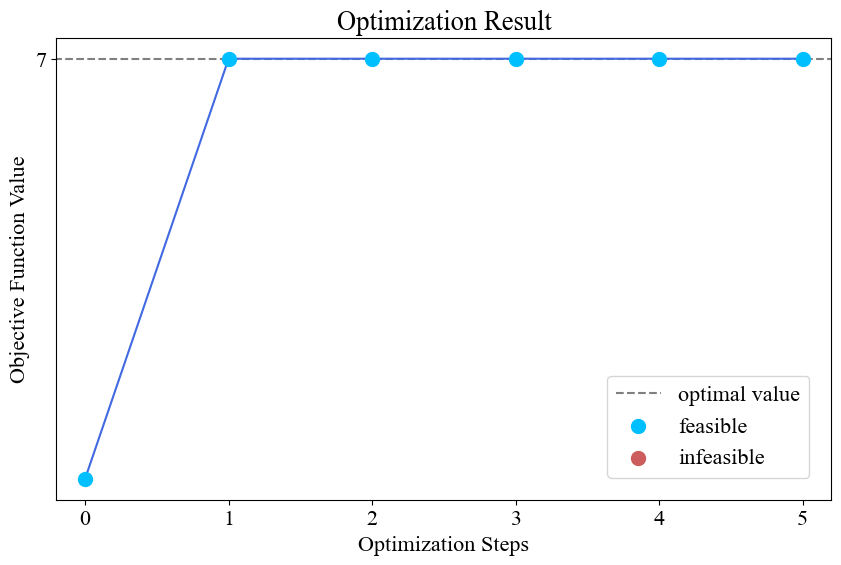

In [11]:
admmt_classical_optimizer.draw(exact_val=cplex_result.fval, fig_size=[10,6], font_size=16)

In [12]:
admm_params = ADMMParameters(
    rho_initial=10, beta=10, factor_c=10, maxiter=100, three_block=True, tol=1.0e-6
)

# initialize ADMM with classical QUBO and convex optimizer
admm = ADMMOptimizer(
    params=admm_params, qubo_optimizer=CplexOptimizer(), continuous_optimizer=CplexOptimizer()
)

# run ADMM to solve problem
admm3b_result = admm.solve(qp)
# print(admm3b_result.prettyprint())

data = admm3b_result.state.residuals

print_solution_summary(qp, cplex_result, 'ADMM-GS (QUBO = CPLEX)')
for step in range(len(data)):
    print(f'step = {step} \t err = {data[step]}')

----------------------------------------------------------------------------------------------------
[ADMM-GS (QUBO = CPLEX) Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 0 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 3.000 6.000 5.000 6.000 0.000 3.000 0.000 3.000 2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------
step = 0 	 err = 0.2230356445336597
step = 1 	 err = 0.10620744974165224
step = 2 	 err = 0.04805766951867678
step = 3 	 err = 0.02061676079153676
step = 4 	 err = 0.008366852287737982
step = 5 	 err = 0.0032050642653051963
step = 6 	 err = 0.0011564112924002071
step = 7 	 err = 0.0003921745195732464
step = 8 	 err = 0.00012475411105129062
step = 9 	 err = 3.71528683760022e-05
step = 10 	 err = 1.0341303198428942e-05
step = 11 	 err = 2.694656564657963e-06
step = 12 	 err = 6.901670117231887e-07


### An improvement with cuts

Under different, possibly approximate HUBO solvers (such as quantum heuristics), the choice of a good initial guess acquires paramount importance. Here we demonstrate how that can be done, by solving a relaxed problem and adding cuts.

In [13]:
qp_cut = generate_cut_problem(qp)

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 28 2021 

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0024I Matrix will be packed to eliminate 441 small elements
Coin0506I Presolve 27 (0) rows, 19 (0) columns and 72 (0) elements
Clp0014I Perturbing problem by 0.001% of 1.3908042 - largest nonzero change 9.7001077e-05 ( 0.0069744594%) - largest zero change 9.2907133e-05
Clp0000I Optimal - objective value 5
Clp0032I Optimal objective 5 - 12 iterations time 0.002


In [14]:
cplex_relaxed = solve_relaxed(qp_cut)
cplex_relaxed.x

objective function value: 5.071428571428571
variable values: x(0,0,1)=0.9761904761904762, x(0,0,2)=1.0, x(0,1,2)=0.07653061224489799, x(1,0,1)=0.0, x(1,0,2)=0.0, x(1,1,2)=1.0, x(2,0,1)=0.9948979591836735, x(2,0,2)=0.9285714285714288, x(2,1,2)=0.0051020408163265085, C=5.071428571428571, y(0,0)=2.071428571428571, y(0,1)=4.0, y(0,2)=4.071428571428571, y(1,0)=4.071428571428571, y(1,1)=0.0, y(1,2)=2.071428571428571, y(2,0)=0.07142857142857117, y(2,1)=2.0, y(2,2)=1.0714285714285712
status: INFEASIBLE


array([0.97619048, 1.        , 0.07653061, 0.        , 0.        ,
       1.        , 0.99489796, 0.92857143, 0.00510204, 5.07142857,
       2.07142857, 4.        , 4.07142857, 4.07142857, 0.        ,
       2.07142857, 0.07142857, 2.        , 1.07142857])

In [15]:
admmt_classical_optimizer = ADMMxClassical_Optimizer(qp)
admm_result = admmt_classical_optimizer.solve(step_max = 5,
                                      x_ini = cplex_relaxed.x,
                                      lam_ini = np.full(qp.get_num_linear_constraints(), 1.),
                                      rho = 10.)

print_solution_summary(qp, admm_result, 'ADMM-T (QUBO = CPLEX)')
print(admmt_classical_optimizer.opt_record)

----------------------------------------------------------------------------------------------------
[ADMM-T (QUBO = CPLEX) Result]
   optimal value: 7.000
   optimal solution (binary): [1 1 1 0 0 1 1 1 0]
   optimal solution (continuous): [7.000 2.334 5.000 6.000 5.893 0.302 3.381 0.000 3.000 2.000]
   status: SUCCESS
----------------------------------------------------------------------------------------------------
        objective function value      status
step 0                  5.071429  infeasible
step 1                  7.000002    feasible
step 2                  7.000001    feasible
step 3                  7.000001    feasible
step 4                  7.000001    feasible
step 5                  7.000001    feasible


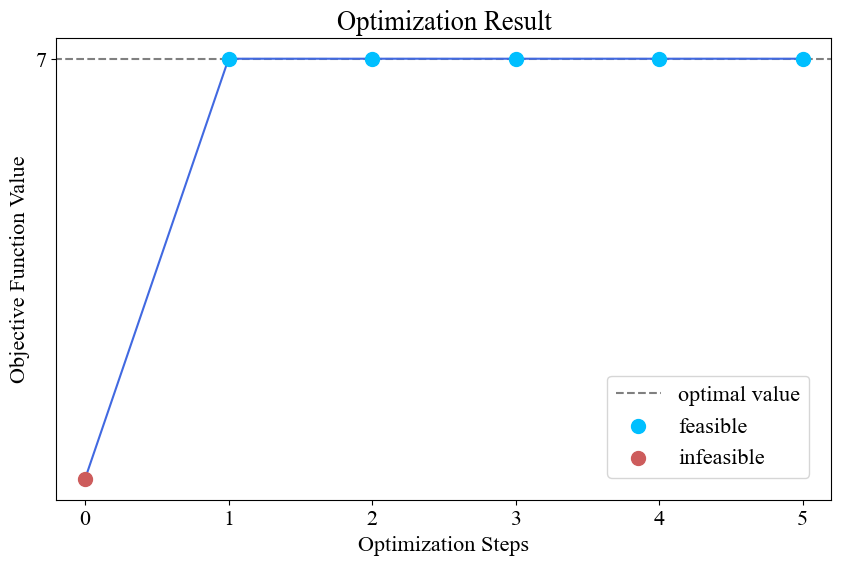

In [16]:
admmt_classical_optimizer.draw(exact_val=cplex_result.fval, fig_size=[10,6], font_size=16)